# Fitting neutrino oscillations with IceCube DeepCore
***Bruno Benkel**, PhD. student at DESY Zeuthen.*

For details on the analysis please see [Measurement of atmospheric neutrino mixing with improved IceCube DeepCore calibration and data processing](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.108.012014), published in Phys. Rev. D 108, 012014 (2023).

Here we present a fit of MC to de data. The aim of this analysis is to show end users how to:
* treat the MC and data;
* compute flux using `daemonflux` (see the [publication](https://arxiv.org/abs/2303.00022) and [repository](https://github.com/mceq-project/daemonflux));
* calculate neutrino oscillation parameters using a 2-flavor approximation; and
* re-weight MC events using the ultrasurfaces gradients (see the [publication](https://iopscience.iop.org/article/10.1088/1748-0221/18/10/P10019) and [repository](https://github.com/LeanderFischer/ultrasurfaces)).

Note that the fit is very simplistic and we ignore many systematic uncertainties, i.e. flux, cross-section, atmospheric muon scale, and normalization. Therefore, we do not expect a high-quality result, just to provide an easy-to-follow procedure.

In [1]:
# Data handling.
import numpy as np
import pandas as pd

from scipy import optimize      # Fitting.
import matplotlib.pyplot as plt # Plotting.
import daemonflux               # Flux estimation.
from copy import deepcopy       # Misc.

---
First, we import the `.csv` files into pandas dataframes and setup binning and livetime from the readme.

In [2]:
# Load the data files.
PATH = "./"
DSETS = ["data", "mc_nue_cc", "mc_numu_cc", "mc_nutau_cc", "mc_nu_nc", "mc_mu"]
dfs = {dataset: pd.read_csv(PATH + dataset + ".csv") for dataset in DSETS}

# Combine MC neutrino sets.
dfs["mc_nu"] = pd.DataFrame()
for k, df in [(k, v) for k, v in dfs.items() if "mc_nu" in k and k != "mc_nu"]:
    dfs["mc_nu"] = pd.concat([dfs["mc_nu"], df], axis=0, ignore_index=True)
    del dfs[k]

# Create quick references to dict entries.
data, mcnu, mcmu = dfs["data"], dfs["mc_nu"], dfs["mc_mu"]

In [3]:
# Setup binning (Available in the README).
EN_MIN, EN_MAX = 6.31, 158.49
CZ_MIN, CZ_MAX = -1., .1

BINS = {
    "reco_energy" : np.logspace(np.log10(EN_MIN), np.log10(EN_MAX), num=12),
    "reco_coszen" : np.linspace(CZ_MIN, CZ_MAX, num=11),
    "pid"         : np.array([0.55, 0.75, 1.00]),
}

# Last energy bin has double size to contain sufficient statistics.
BINS["reco_energy"] = np.delete(BINS["reco_energy"], -2)

# Calculate livetime from Table III in https://arxiv.org/abs/2304.12236.
YEAR2SEC = 31557600
PAPER_CONDS = {
    11: [96.4/1e6, 0.67],
    12: [93.0/1e6, 0.87],
    13: [90.0/1e6, 0.92],
    14: [93.7/1e6, 0.96],
    15: [95.3/1e6, 0.98],
    16: [90.1/1e6, 0.96],
    17: [94.1/1e6, 1.10],
    18: [94.1/1e6, 0.99],
}
NUCOUNT = sum([YEAR2SEC * v[0] * v[1] for v in PAPER_CONDS.values()])

---
Then, we estimate neutrino flux using `daemonflux` and prepare functions to estimate neutrino oscillation using the 2-flavor approximation.

In [4]:
# Downsize input MC data for expediency.
SCALING_FACTOR = 10
mcnu = mcnu.iloc[::SCALING_FACTOR, :].reset_index(drop=True)

# Normalize weights after scaling.
mcnu["weight"] *= SCALING_FACTOR

In [5]:
# Get flux using daemonflux (see https://github.com/mceq-project/daemonflux).
FLAVORS = ("nue", "numu")
dflux = daemonflux.Flux(location = "generic")

# Store nu flux in corresponding arrays.
flux = {}
for fl in FLAVORS:
    flux[fl] = np.zeros_like(mcnu["weight"])

print("Progress:")
for ei in range(len(mcnu)):
    # Check if nu or antinu.
    prefix = ""
    if mcnu["pdg"][ei] < 0: prefix = "anti"

    # Get zenith angle in degrees, from -90 to 90.
    zen = np.rad2deg(np.arccos(mcnu["true_coszen"][ei]))
    if zen > 90: zen = 180-zen

    # Get flux.
    for fl in FLAVORS:
        flux[fl][ei] = dflux.flux([mcnu["true_energy"][ei]], zen, prefix+fl)

    # Print progress.
    if ei % 1e4 == 0: print("%6d | %6d" % (ei, len(mcnu)))
print("Done!")

# Correct flux -- daemonflux reports E^3 * flux in [GeV^-4 m^-2 s^-1 sr^-1], our
#     weight is in [GeV cm^2 sr].
for fl in FLAVORS:
    flux[fl] *= 1e4 # m^2 -> cm^2.
    mcnu[fl + "_flux"] = flux[fl] / pow(mcnu["true_energy"], 3) # GeV^-4 -> -1.

Progress:
     0 |  39684
 10000 |  39684
 20000 |  39684
 30000 |  39684
Done!


In [6]:
# Define functions to obtain oscillated flux, so that we can later fit.
TAGS = {
    "nu_nc"    :  mcnu["type"] == 0,
    "nue_nc"   : (mcnu["type"] == 0) * (mcnu["pdg"]%12 == 0),
    "numu_nc"  : (mcnu["type"] == 0) * (mcnu["pdg"]%14 == 0),
    "nue_cc"   : (mcnu["type"] != 0) * (mcnu["pdg"]%12 == 0),
    "numu_cc"  : (mcnu["type"] != 0) * (mcnu["pdg"]%14 == 0),
    "nutau_cc" : (mcnu["type"] != 0) * (mcnu["pdg"]%16 == 0),
}

# Constants to associate zenith angle with distance.
L1 = 19.
R  = 6378.2 + L1
def zen_to_d(coszen: float):
    """
    Converts the cosine of the zenith angle into distance.

    Args:
        coszen  : cosine of the zenith angle of the event.
        returns : event's distance in meters.
    """
    zen = np.arccos(coszen)
    phi = np.arcsin((1-L1/R) * np.sin(zen))
    psi = zen - phi
    return np.sqrt((R-L1)**2 + R**2 - (2*(R-L1) * R * np.cos(psi)))

def osc_flux(mcnu: pd.DataFrame, amp: float, dm31: float):
    """
    Computes neutrino transition probability using the 2-flavor approximation,
    returning an oscillated flux array that takes muon neutrino disappearance
    and tau neutrino appearance into account.

    Args:
        mcnu    : pandas dataframe with MC neutrinos.
        amp     : real value for the sin2(2 * theta23) in the 2-flavor approx-
                  imation.
        dm31    : neutrino mass splitting in eV^2.
        returns : array with the oscillated flux.
    """
    prop_distance = zen_to_d(mcnu["true_coszen"]) / mcnu["true_energy"]
    ptau = amp * np.sin(1.267 * dm31 * prop_distance)**2

    # Compute oscillated flux.
    oflux = np.zeros_like(mcnu["weight"])

    for fl in FLAVORS:
        oflux[TAGS[fl+"_nc"]] = deepcopy(mcnu[fl+"_flux"][TAGS[fl+"_nc"]])
    oflux[TAGS["nue_cc"]]   = deepcopy(mcnu["nue_flux"][TAGS["nue_cc"]])
    oflux[TAGS["numu_cc"]]  = mcnu["numu_flux"][TAGS["numu_cc"]] *\
                              (1-ptau[TAGS["numu_cc"]])
    oflux[TAGS["nutau_cc"]] = mcnu["numu_flux"][TAGS["nutau_cc"]] *\
                              ptau[TAGS["nutau_cc"]]

    return oflux

---
Reweight events in the dataframe using ultrasurfaces. We also plot a histogram showing the effect of ultrasurfaces on the MC neutrino histogram.

In [7]:
# Setup ultrasurfaces parameters.
NOMINAL_SYSTEMATICS = { # From readme.
    "dom_eff" :  1.,
    "hi_p0"   :  0.101569,
    "hi_p1"   : -0.049344,
    "bi_abs"  :  1.,
    "bi_scat" :  1.05,
}

BESTFIT_SYSTEMATICS = { # From Table IV in https://arxiv.org/abs/2304.12236.
    "dom_eff" :  1.06,
    "hi_p0"   : -0.27,
    "hi_p1"   : -0.04,
    "bi_abs"  :  0.97,
    "bi_scat" :  0.99,
}

def ultrasurfaces_reweight(df: pd.DataFrame, fit: dict[float]):
    """
    Reweight events using the event-by-event correction factors included from
    the ultrasurfaces method.
    """
    # Compute difference between best fit and nominal systematics.
    syst_diff = {k: fit[k] - v for k, v in NOMINAL_SYSTEMATICS.items()}

    # Reweight.
    for k, v in syst_diff.items():
        df["weight"] *= (1. + df["grad_"+k]*v + df["grad2_"+k]*v**2)
    return df

# Reweight in dataframe.
old_weights = mcnu["weight"].copy(deep = True)
mcnu = ultrasurfaces_reweight(mcnu, fit = BESTFIT_SYSTEMATICS)

Total weight
  * Before US : 1.03
  * After US  : 1.05


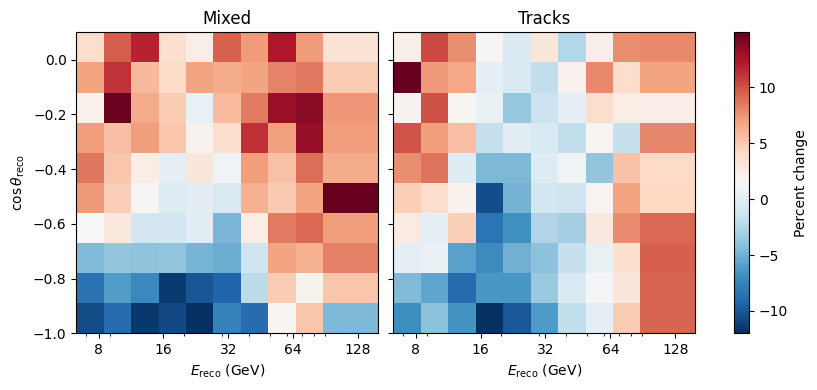

In [8]:
def plot_hist(hist: np.array, cmap: str = "OrRd"):
    """
    Plot a 3D histogram, separating it into two 2D histograms by PID.

    Args:
        hist : histogram we should plot.
        cmap : color map to use. Default is "OrRd".
    """
    fig, axs = plt.subplots(ncols=2, figsize=(9,4), sharey="row")
    for pi in range(2):
        phist = axs[pi].pcolormesh(
            BINS["reco_energy"], BINS["reco_coszen"],
            hist[:,:,pi].T, cmap = cmap
        )
        axs[pi].set_xscale("log")
        XTICKS = np.logspace(3, 7, num=5, base=2)
        axs[pi].set_xticks(XTICKS, XTICKS.astype(int))
        axs[pi].set_xlabel(r"$E_\text{reco}$ (GeV)")
        axs[pi].set_title("Mixed" if BINS["pid"][pi] == 0.55 else "Tracks")
    axs[0].set_ylabel(r"$\cos \theta_\text{reco}$")
    plt.tight_layout()

    fig.subplots_adjust(right=0.95)
    cbar = fig.colorbar(phist, ax=axs)
    if cmap == "RdBu_r": cbar.set_label("Percent change")
    else:                cbar.set_label("Count")

    plt.show()

# Prepare some test parameters for the oscillated flux.
T_AMP  = 1.
T_DM31 = 1.5e-3
T_OFLUX = osc_flux(mcnu, T_AMP, T_DM31)

# Make MC neutrino histogram with pre- and post-ultrasurfaces weights.
h_mcnu_ow, _ = np.histogramdd(
    [mcnu["reco_energy"], mcnu["reco_coszen"], mcnu["pid"]],
    weights = NUCOUNT * T_OFLUX * old_weights, bins = list(BINS.values())
)
h_mcnu, _ = np.histogramdd(
    [mcnu["reco_energy"], mcnu["reco_coszen"], mcnu["pid"]],
    weights = NUCOUNT * T_OFLUX * mcnu["weight"], bins = list(BINS.values())
)

# Plot.
print("Total weight")
print("  * Before US : %.2f" % sum(T_OFLUX * old_weights))
print("  * After US  : %.2f" % sum(T_OFLUX * mcnu["weight"]))
plot_hist(100 * (h_mcnu - h_mcnu_ow) / h_mcnu_ow, cmap="RdBu_r")

---
Make data and MC muon histograms. At this point, we can also visually compare MC with the data histograms. Please note that in this analysis we are not accounting for many of the systematics in Table IV, which should explain the difference in scale between data events and MC.

In [9]:
# Data histogram - we won't change this.
h_data, _ = np.histogramdd(
    [data["reco_energy"], data["reco_coszen"], data["pid"]],
    bins = list(BINS.values()), weights = data["count"]
)
# Muon histogram - in this analysis we won't change this, just rescale it by a
#     factor.
h_mcmu, _ = np.histogramdd(
    [mcmu["reco_energy"], mcmu["reco_coszen"], mcmu["pid"]],
    bins = list(BINS.values()), weights = mcmu["count"]
)

Data events (sum: 21914)


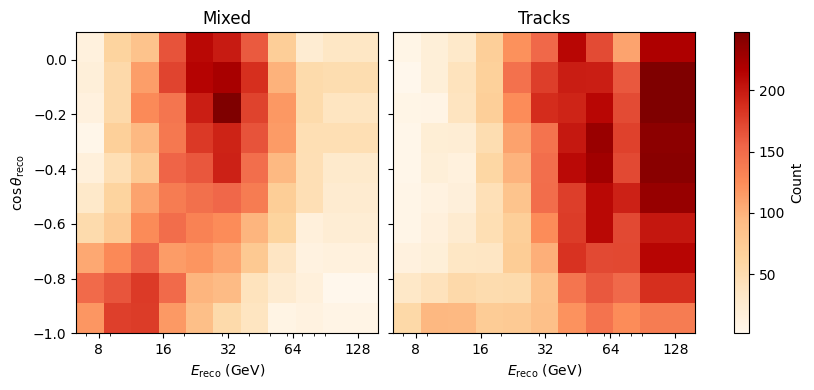

MC events (sum: 23274)


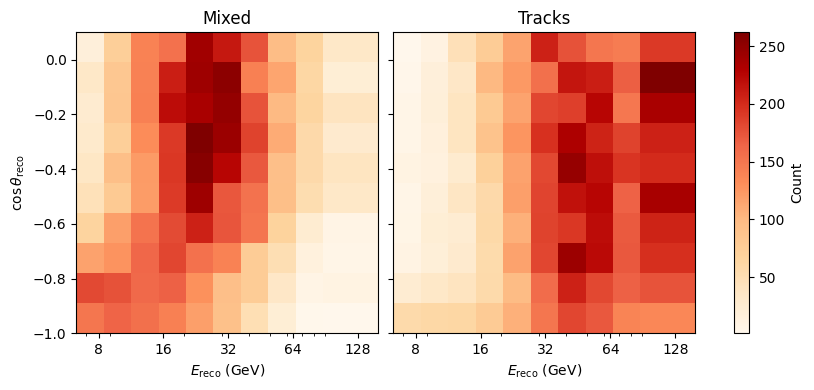

In [10]:
print("Data events (sum: %d)" % h_data.sum())
plot_hist(h_data)

print("MC events (sum: %d)" % (h_mcnu.sum() + h_mcmu.sum()))
plot_hist(h_mcnu + h_mcmu)

---
Prepare functions necessary for the analysis, like reweighting the MC neutrino histogram with different physics parameters and a modified $\chi^2$ measure.

In [11]:
def eval_weights(
    mcnu: pd.DataFrame, h_data: np.array, h_mcmu: np.array,
    amp: float, dm31: float, mu_frac: float
):
    """
    Makes the MC neutrino histogram re-evaluating the weights based on an oscil-
    lated flux evaluated from physics parameters. Then, returns both the MC neu-
    trino and MC muon histograms rescaled by a global factor.

    Args:
        mcnu    : pandas dataframe with MC neutrino data.
        h_data  : numpy array with 3D data histogram.
        h_mcmu  : numpy array with 3D MC muon histogram.
        amp     : real value for the sin2(2 * theta23) in the 2-flavor approx-
                  imation.
        dm31    : neutrino mass splitting in eV^2.
        mu_frac : fraction of the sample composed of atmospheric muon back-
                  ground.
        returns : MC neutrino and muon histograms, scaled by mu_frac.
    """
    # Get oscillated weight.
    oflux = osc_flux(mcnu, amp, dm31)

    # Make the MC neutrino histogram.
    h_mcnu, _ = np.histogramdd(
        [mcnu["reco_energy"], mcnu["reco_coszen"], mcnu["pid"]],
        bins = list(BINS.values()), weights = NUCOUNT * oflux * mcnu["weight"]
    )

    # Scale the number of nu events to match the data.
    nu_scale = h_data.sum() * (1 - mu_frac) / h_mcnu.sum()
    mu_scale = h_data.sum() * mu_frac       / h_mcmu.sum()

    return nu_scale * h_mcnu, mu_scale * h_mcmu

def draw_1Dplots(h_data: np.array, h_mc: np.array):
    """
    Draws a set of 1D plots to compare the expectation from MC neutrinos and
    muons with the data.

    Args:
        h_data : numpy array with the 3D data histogram.
        h_mc   : numpy array with the 3D MC neutrino and muon histograms added
                 together.
    """
    BE, BC, BP = BINS["reco_energy"], BINS["reco_coszen"], BINS["pid"]
    NROWS, NCOLS = len(BE)-1, len(BP)-1
    fig, axs = plt.subplots(
        nrows = NROWS, ncols = NCOLS, figsize = (7,12), sharex = True
    )

    for ci in range(NCOLS):
        for ri in range(NROWS):
            # Draw expectation.
            bc = np.append(h_mc[ri,:,ci], np.array([h_mc[ri,-1,ci]]))
            axs[ri][ci].fill_between(
                BC, bc-np.sqrt(bc), bc+np.sqrt(bc), color="coral", step="post",
                label="Expectation"
            )

            # Draw data.
            axs[ri][ci].stairs(h_data[ri,:,ci], BC, color="k", label="Data")

    axs[0][0].set_title("Mixed")
    axs[0][1].set_title("Tracks")
    for ci in range(NCOLS):
        axs[NROWS-1][ci].set_xlabel(r"$\cos(\theta_\text{reco})$")
    for ri in range(NROWS):
        axs[ri][0].set_ylabel("Count")
        axs[ri][0].text(
            0.3, 0.1, "E = [%4.1f, %4.1f] GeV" % (BE[ri], BE[ri+1]),
            transform = axs[ri][0].transAxes
        )

    axs[0][1].legend()
    plt.tight_layout()
    plt.show()

# Run the fit.
# Define chi2 calculation.
def chi2(params: list[float]):
    """
    Calculates a simplified chi2. For simplicity, this function assumes that
    `mcnu`, `h_data`, and `h_mcmu` are defined outside the scope of this func-
    tion.

    Args:
        params  : list containing the amplitude, dm31, and muon fraction.
        returns : the calculated chi2.
    """
    amp     = params[0]
    dm31    = params[1]
    mu_frac = params[2]

    # Get MC histogram.
    h_mcnu_s, h_mcmu_s = eval_weights(mcnu, h_data, h_mcmu, amp, dm31, mu_frac)
    mc_total = h_mcnu_s + h_mcmu_s

    # Compute and return chi2.
    chi2 = (h_data - mc_total)**2 / mc_total
    chi2[np.isnan(chi2)] = 0.
    return chi2.sum() / (len(params) * np.sqrt(np.sum(h_data)))

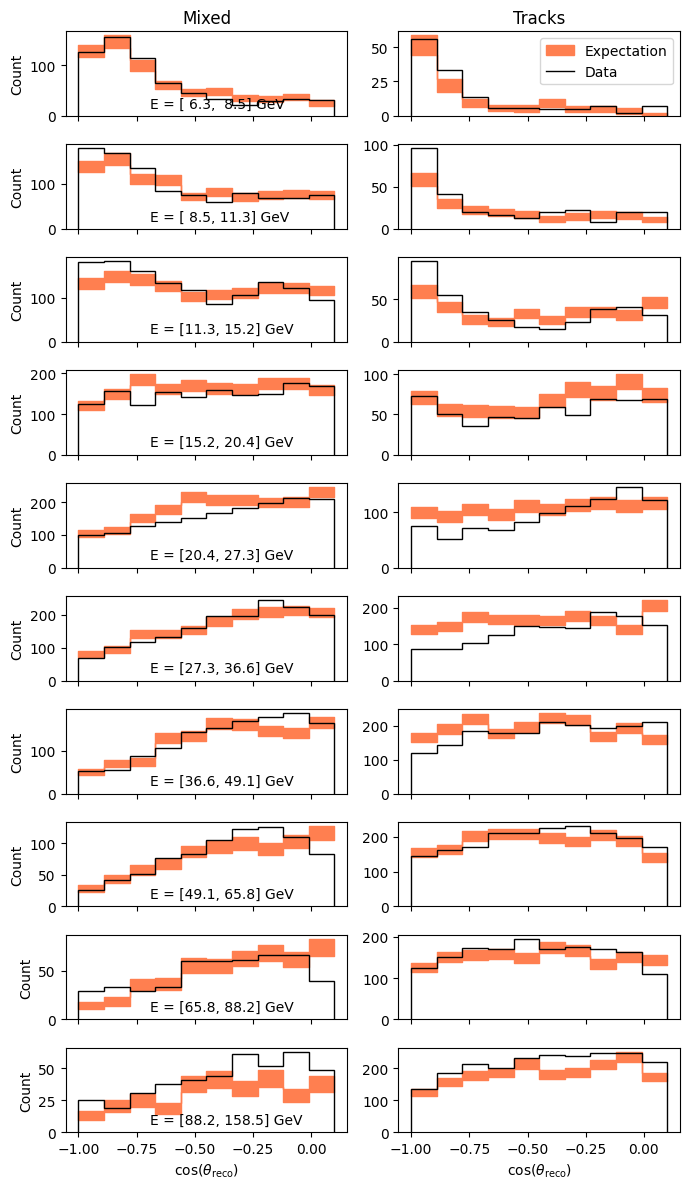

In [12]:
# Draw 1D plots with test parameters to see if we get something sensible.
T_MUFRAC = 0.05

h_mcnu_s, h_mcmu_s = eval_weights(mcnu, h_data, h_mcmu, T_AMP, T_DM31, T_MUFRAC)
draw_1Dplots(h_data, h_mcnu_s+h_mcmu_s)

---
Run the fit and plot results.

dm32^2 = 0.002214
amp    = 1.037850
chi2   = 1.247559 (dof: 3)


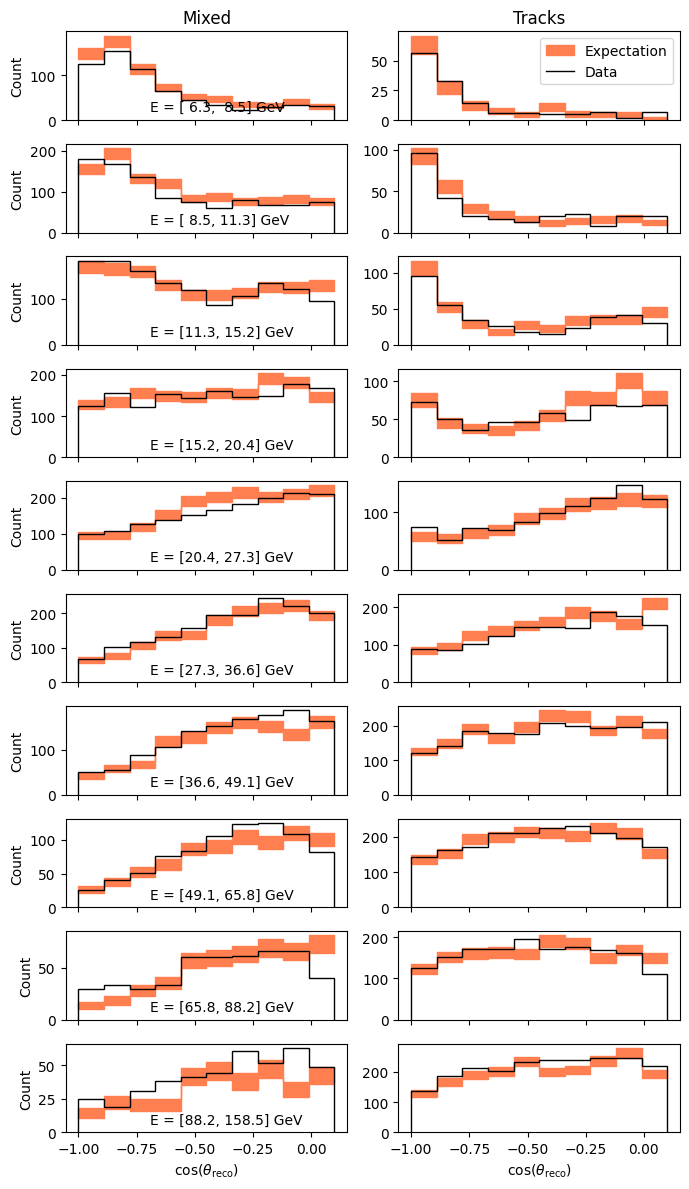

In [13]:
result = optimize.minimize(chi2, [T_AMP, T_DM31, T_MUFRAC], method="L-BFGS-B")
print("dm32^2 = %f" % result.x[1])
print("amp    = %f" % result.x[0])
print("chi2   = %f (dof: %d)" % (chi2(result.x), len(result.x)))

# Plot the result.
h_mcnu_s, h_mcmu_s = eval_weights(mcnu, h_data, h_mcmu, *result.x)
h_mc = h_mcnu_s + h_mcmu_s
draw_1Dplots(h_data, h_mc)